In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
base_path = Path("result/20240307_steady_temperature")

csv_files = list(base_path.glob("*/s3/result.csv"))
sorted_csv_files = sorted(
    csv_files, key=lambda x: x.parent.parent.name.split("_")[:2]
)

In [3]:
max_tpu_temp_list = []
amb_temp_list = []

for file_path in sorted_csv_files:
    df = pd.read_csv(file_path)
    max_tpu_temp = df["TPU Temperature"].max()
    max_tpu_temp_list.append(max_tpu_temp)

    amb_temp = df.loc[df["TPU Temperature"] == max_tpu_temp, "Ambient Temperature"].iloc[0]
    amb_temp_list.append(amb_temp)

In [4]:
# MobileNetV2
max_tpu_temp_list_1 = max_tpu_temp_list[:10]
amb_temp_list_1 = amb_temp_list[:10]

# EfficientNet-L
max_tpu_temp_list_2 = max_tpu_temp_list[10:20]
amb_temp_list_2 = amb_temp_list[10:20]

# SSD-MobileNetV2
max_tpu_temp_list_3 = max_tpu_temp_list[20:]
amb_temp_list_3 = amb_temp_list[20:]

In [43]:
p_dyn_list = []
R = 11.5
# b_1 = 0.02
# b_2 = 2.408

# R = 10.16
b_1 = 0.0138
b_2 = 2.408

# calc first
t_infty = max_tpu_temp_list_1[0]
t_amb = amb_temp_list_1[0]
P_dyn = (t_infty - t_amb - (b_1 * t_infty + b_2) * R) / R
p_dyn_list.append(P_dyn)

# calc second
t_infty = max_tpu_temp_list_2[0]
t_amb = amb_temp_list_2[0]
P_dyn = (t_infty - t_amb - (b_1 * t_infty + b_2) * R) / R
p_dyn_list.append(P_dyn)

# calc third
t_infty = max_tpu_temp_list_3[0]
t_amb = amb_temp_list_3[0]
P_dyn = (t_infty - t_amb - (b_1 * t_infty + b_2) * R) / R
p_dyn_list.append(P_dyn)

In [6]:
def calc_max_tpu_temp(
    util, p_dyn, t_amb, R, b_1, b_2, tolerance=0.0001
):
    # Initialize max_tpu_temp with ambient temperature
    max_tpu_temp = t_amb

    while True:
        # Calculate p_leak using the current max_tpu_temp
        p_leak = b_1 * max_tpu_temp + b_2

        # Calculate the new max_tpu_temp using the formula
        new_max_tpu_temp = t_amb + (p_dyn * util + p_leak) * R

        # Check if the difference between new_max_tpu_temp
        # and max_tpu_temp is within the tolerance
        if abs(new_max_tpu_temp - max_tpu_temp) < tolerance:
            break

        # Update max_tpu_temp with the new value
        max_tpu_temp = new_max_tpu_temp

    return max_tpu_temp

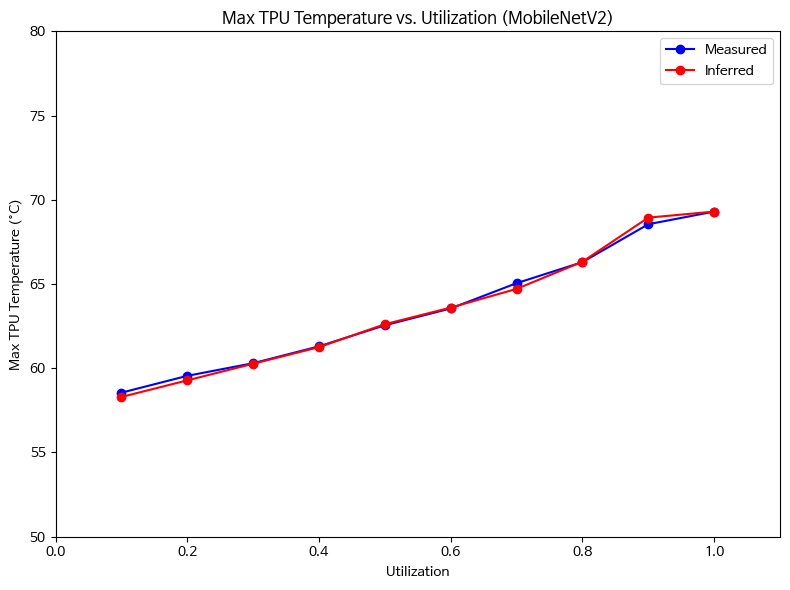

error mean: 0.15, error std: 0.14


In [44]:
measures = list(reversed(max_tpu_temp_list_1))
t_ambs = list(reversed(amb_temp_list_1))
p_dyn = p_dyn_list[0]
utilization = np.arange(0.1, 1.1, 0.1)

inferred_max_tpu_temp = [
    calc_max_tpu_temp(util, p_dyn, t_amb, R, b_1, b_2)
    for util, t_amb in zip(utilization, t_ambs)
]

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot max_tpu_temp_list_1 vs. utilization as blue dots
ax.plot(utilization, measures, "bo-", label="Measured")
ax.plot(utilization, inferred_max_tpu_temp, "ro-", label="Inferred")

ax.set_xlabel("Utilization")
ax.set_ylabel("Max TPU Temperature (°C)")
ax.set_title("Max TPU Temperature vs. Utilization (MobileNetV2)")

ax.set_xlim(0, 1.1)
ax.set_ylim(50, 80)
ax.legend()
plt.tight_layout()
plt.show()

errors = np.array(
    [abs(x - y) for x, y in zip(measures, inferred_max_tpu_temp)]
)
print(f"error mean: {errors.mean():.2f}, error std: {errors.std():.2f}")

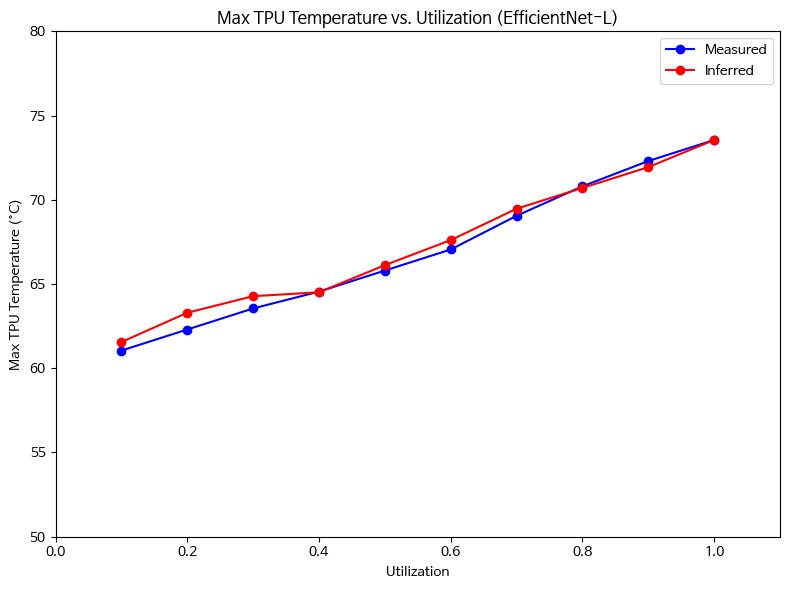

error mean: 0.40, error std: 0.30


In [45]:
measures = list(reversed(max_tpu_temp_list_2))
t_ambs = list(reversed(amb_temp_list_2))
p_dyn = p_dyn_list[1]
utilization = np.arange(0.1, 1.1, 0.1)

inferred_max_tpu_temp = [
    calc_max_tpu_temp(util, p_dyn, t_amb, R, b_1, b_2)
    for util, t_amb in zip(utilization, t_ambs)
]

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot max_tpu_temp_list_1 vs. utilization as blue dots
ax.plot(utilization, measures, "bo-", label="Measured")
ax.plot(utilization, inferred_max_tpu_temp, "ro-", label="Inferred")

ax.set_xlabel("Utilization")
ax.set_ylabel("Max TPU Temperature (°C)")
ax.set_title("Max TPU Temperature vs. Utilization (EfficientNet-L)")

ax.set_xlim(0, 1.1)
ax.set_ylim(50, 80)
ax.legend()
plt.tight_layout()
plt.show()

errors = np.array(
    [abs(x - y) for x, y in zip(measures, inferred_max_tpu_temp)]
)
print(f"error mean: {errors.mean():.2f}, error std: {errors.std():.2f}")

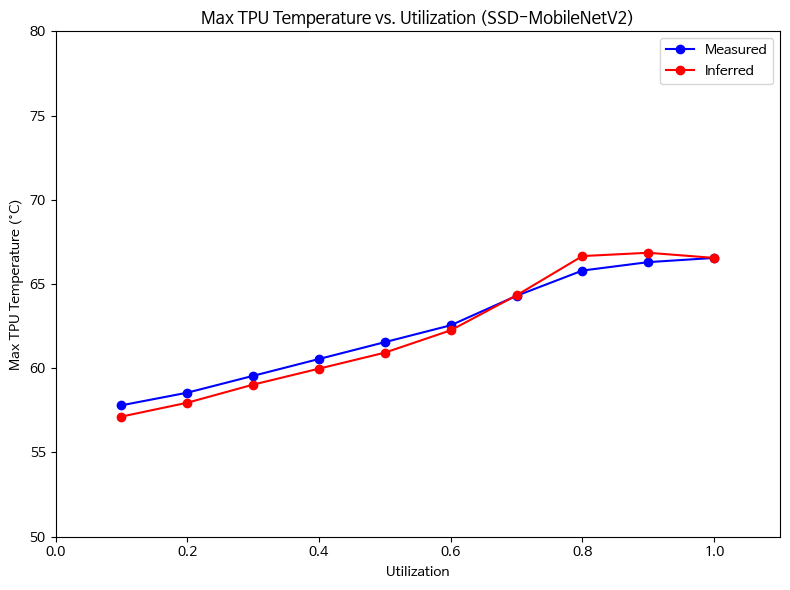

error mean: 0.47, error std: 0.26


In [46]:
measures = list(reversed(max_tpu_temp_list_3))
t_ambs = list(reversed(amb_temp_list_3))
p_dyn = p_dyn_list[2]
utilization = np.arange(0.1, 1.1, 0.1)

inferred_max_tpu_temp = [
    calc_max_tpu_temp(util, p_dyn, t_amb, R, b_1, b_2)
    for util, t_amb in zip(utilization, t_ambs)
]

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot max_tpu_temp_list_1 vs. utilization as blue dots
ax.plot(utilization, measures, "bo-", label="Measured")
ax.plot(utilization, inferred_max_tpu_temp, "ro-", label="Inferred")

ax.set_xlabel("Utilization")
ax.set_ylabel("Max TPU Temperature (°C)")
ax.set_title("Max TPU Temperature vs. Utilization (SSD-MobileNetV2)")

ax.set_xlim(0, 1.1)
ax.set_ylim(50, 80)
ax.legend()
plt.tight_layout()
plt.show()

errors = np.array(
    [abs(x - y) for x, y in zip(measures, inferred_max_tpu_temp)]
)
print(f"error mean: {errors.mean():.2f}, error std: {errors.std():.2f}")